In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('poster')  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix
from python.cogtext.similarity_matrix import multivariate_normal_kl, multivariate_normal_js
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/cogtext/abstracts_clusters.csv.gz', index_col=0)
weights = np.load('models/cogtext/abstracts_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

In [2]:
n_popular_labels = 20
popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())
pubmed = pubmed.query('label in @popular_labels')

X = pubmed.groupby('label')['weights'].apply(lambda x: np.stack(x))

In [3]:
losses = np.zeros((X.shape[0], X.shape[0]))

for i,xi in tqdm(enumerate(X), total=X.shape[0]):
  for j,xj in enumerate(X):
    losses[i,j] = multivariate_normal_kl(xi, xj)

losses = pd.DataFrame(losses, X.index, X.index)
max_loss = losses.replace([np.inf],0).max().max()
losses.replace([np.inf, np.nan], max_loss, inplace=True)

losses.to_csv('models/cogtext/multivariate_normal_losses.csv')

  0%|          | 0/40 [00:00<?, ?it/s]

## Tasks and constructs together

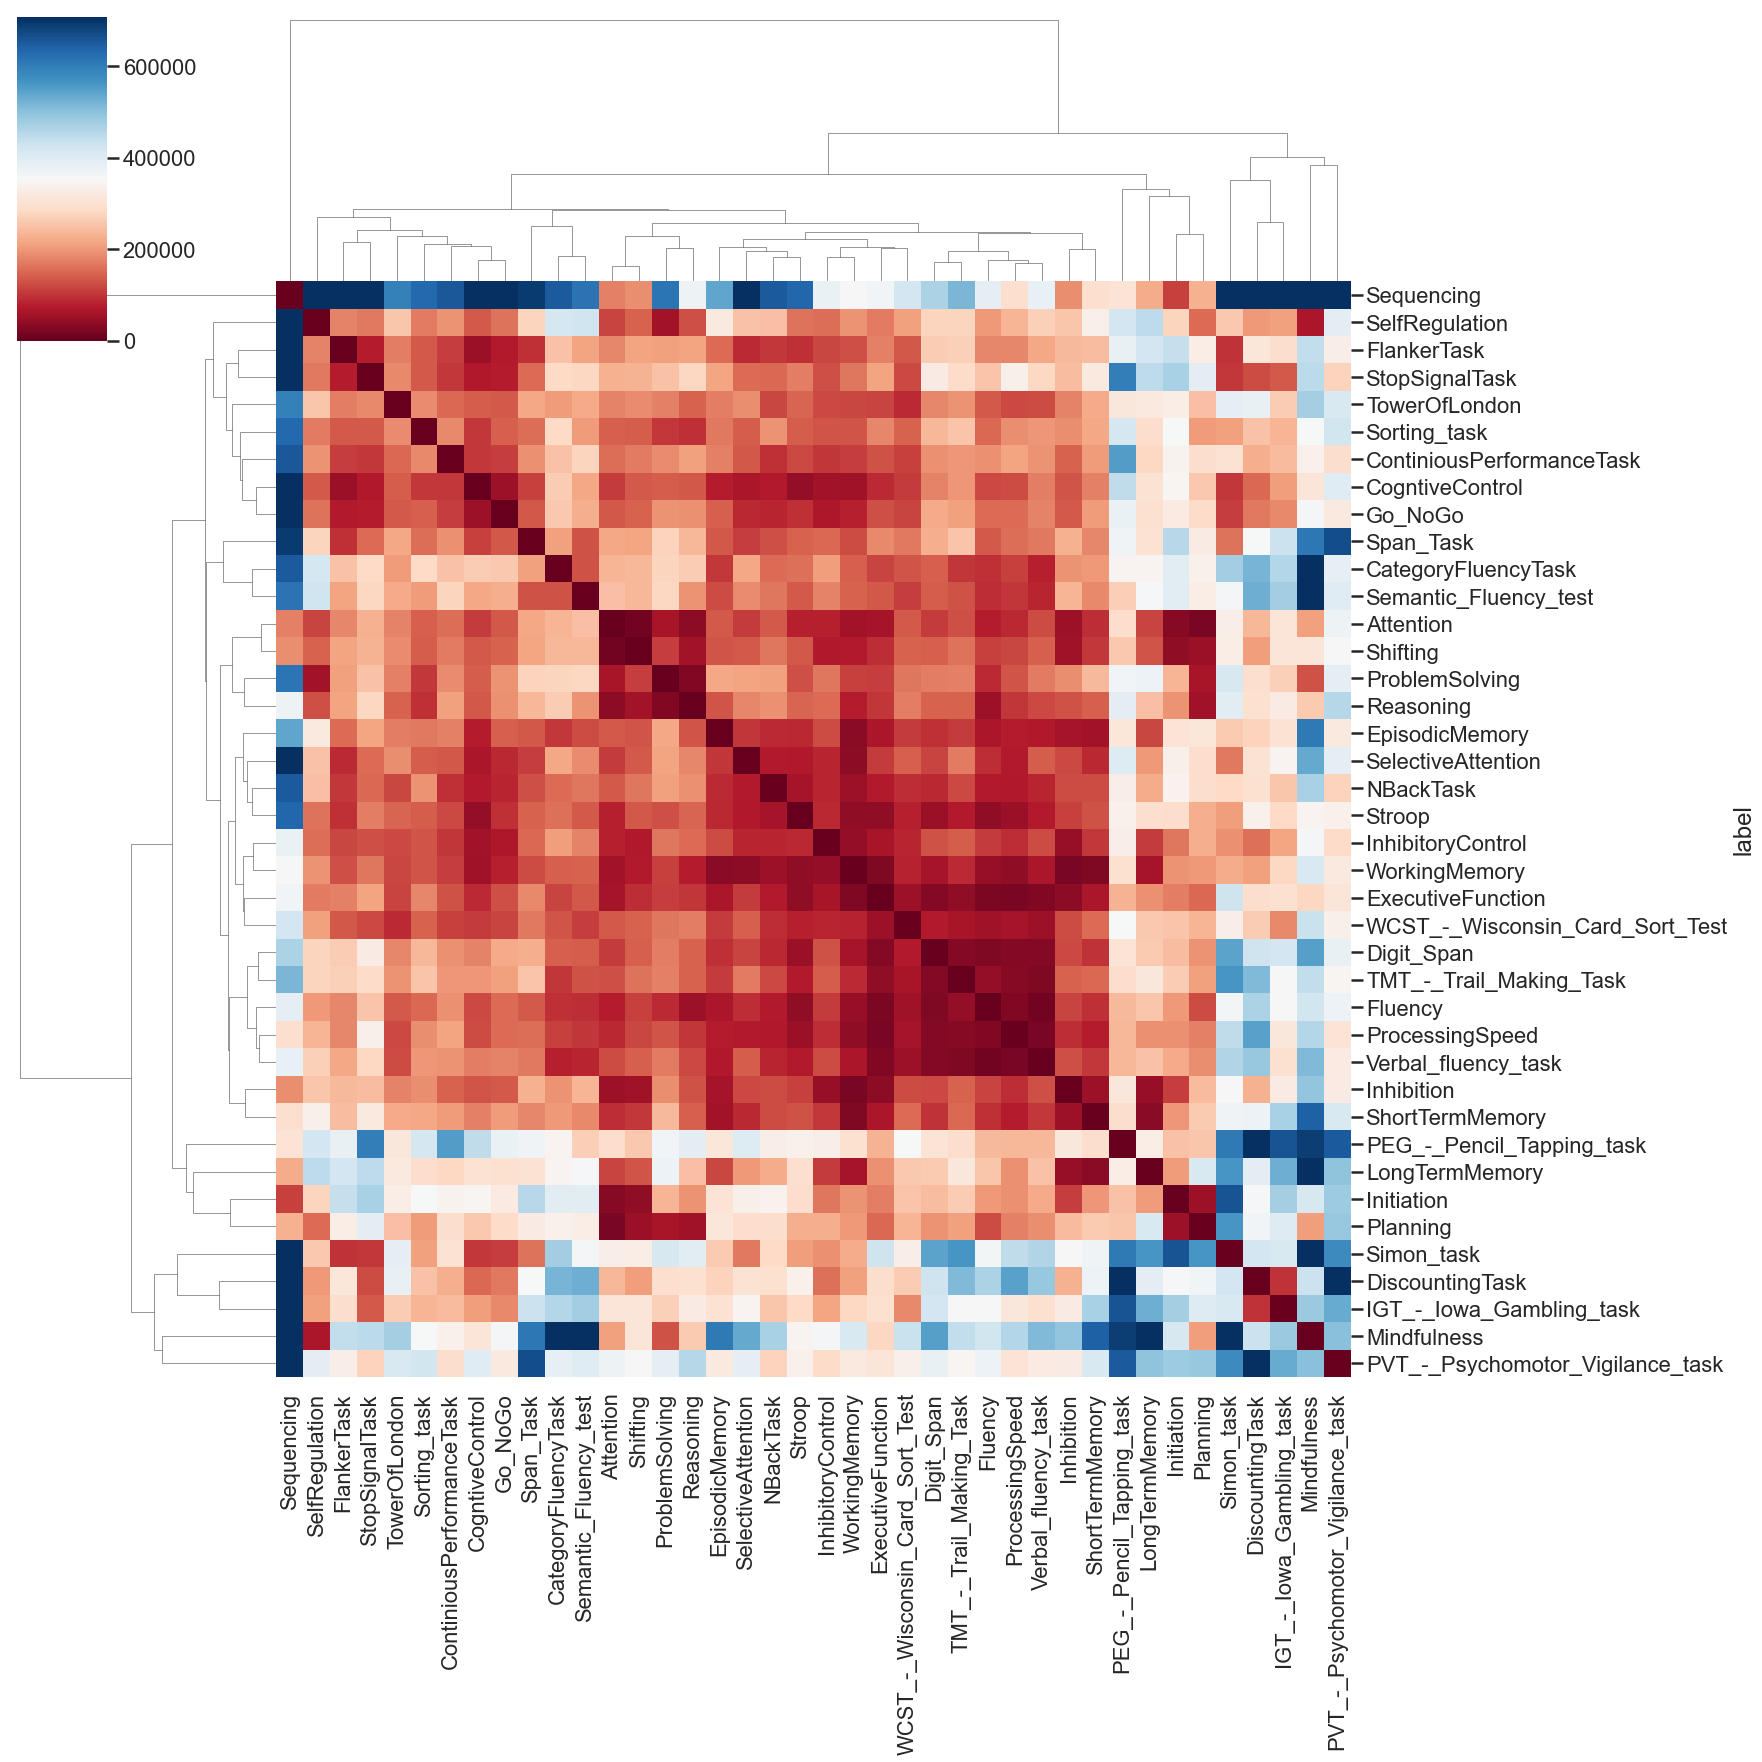

In [44]:
losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv', index_col=0)

# tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
# constructs = pubmed.query('category.str.contains("Construct")')['label'].unique()

# losses.drop(columns=constructs, inplace=True)
# losses.drop(index=tasks, inplace=True)

# rare_labels = pubmed.query('label not in @popular_labels')['label'].unique()
# losses.drop(index=rare_labels, columns=rare_labels, inplace=True, errors='ignore')

# losses.drop(index=tasks, columns=tasks, inplace=True, errors='ignore')
# losses.drop(index=rare_labels, columns=rare_labels, inplace=True, errors='ignore')

# drop tasks from rows and columns

sns.clustermap(
  losses,
  figsize=(25,25),
  cmap='RdBu', robust=True)

plt.suptitle('JS losses')
plt.show()


## Constructs

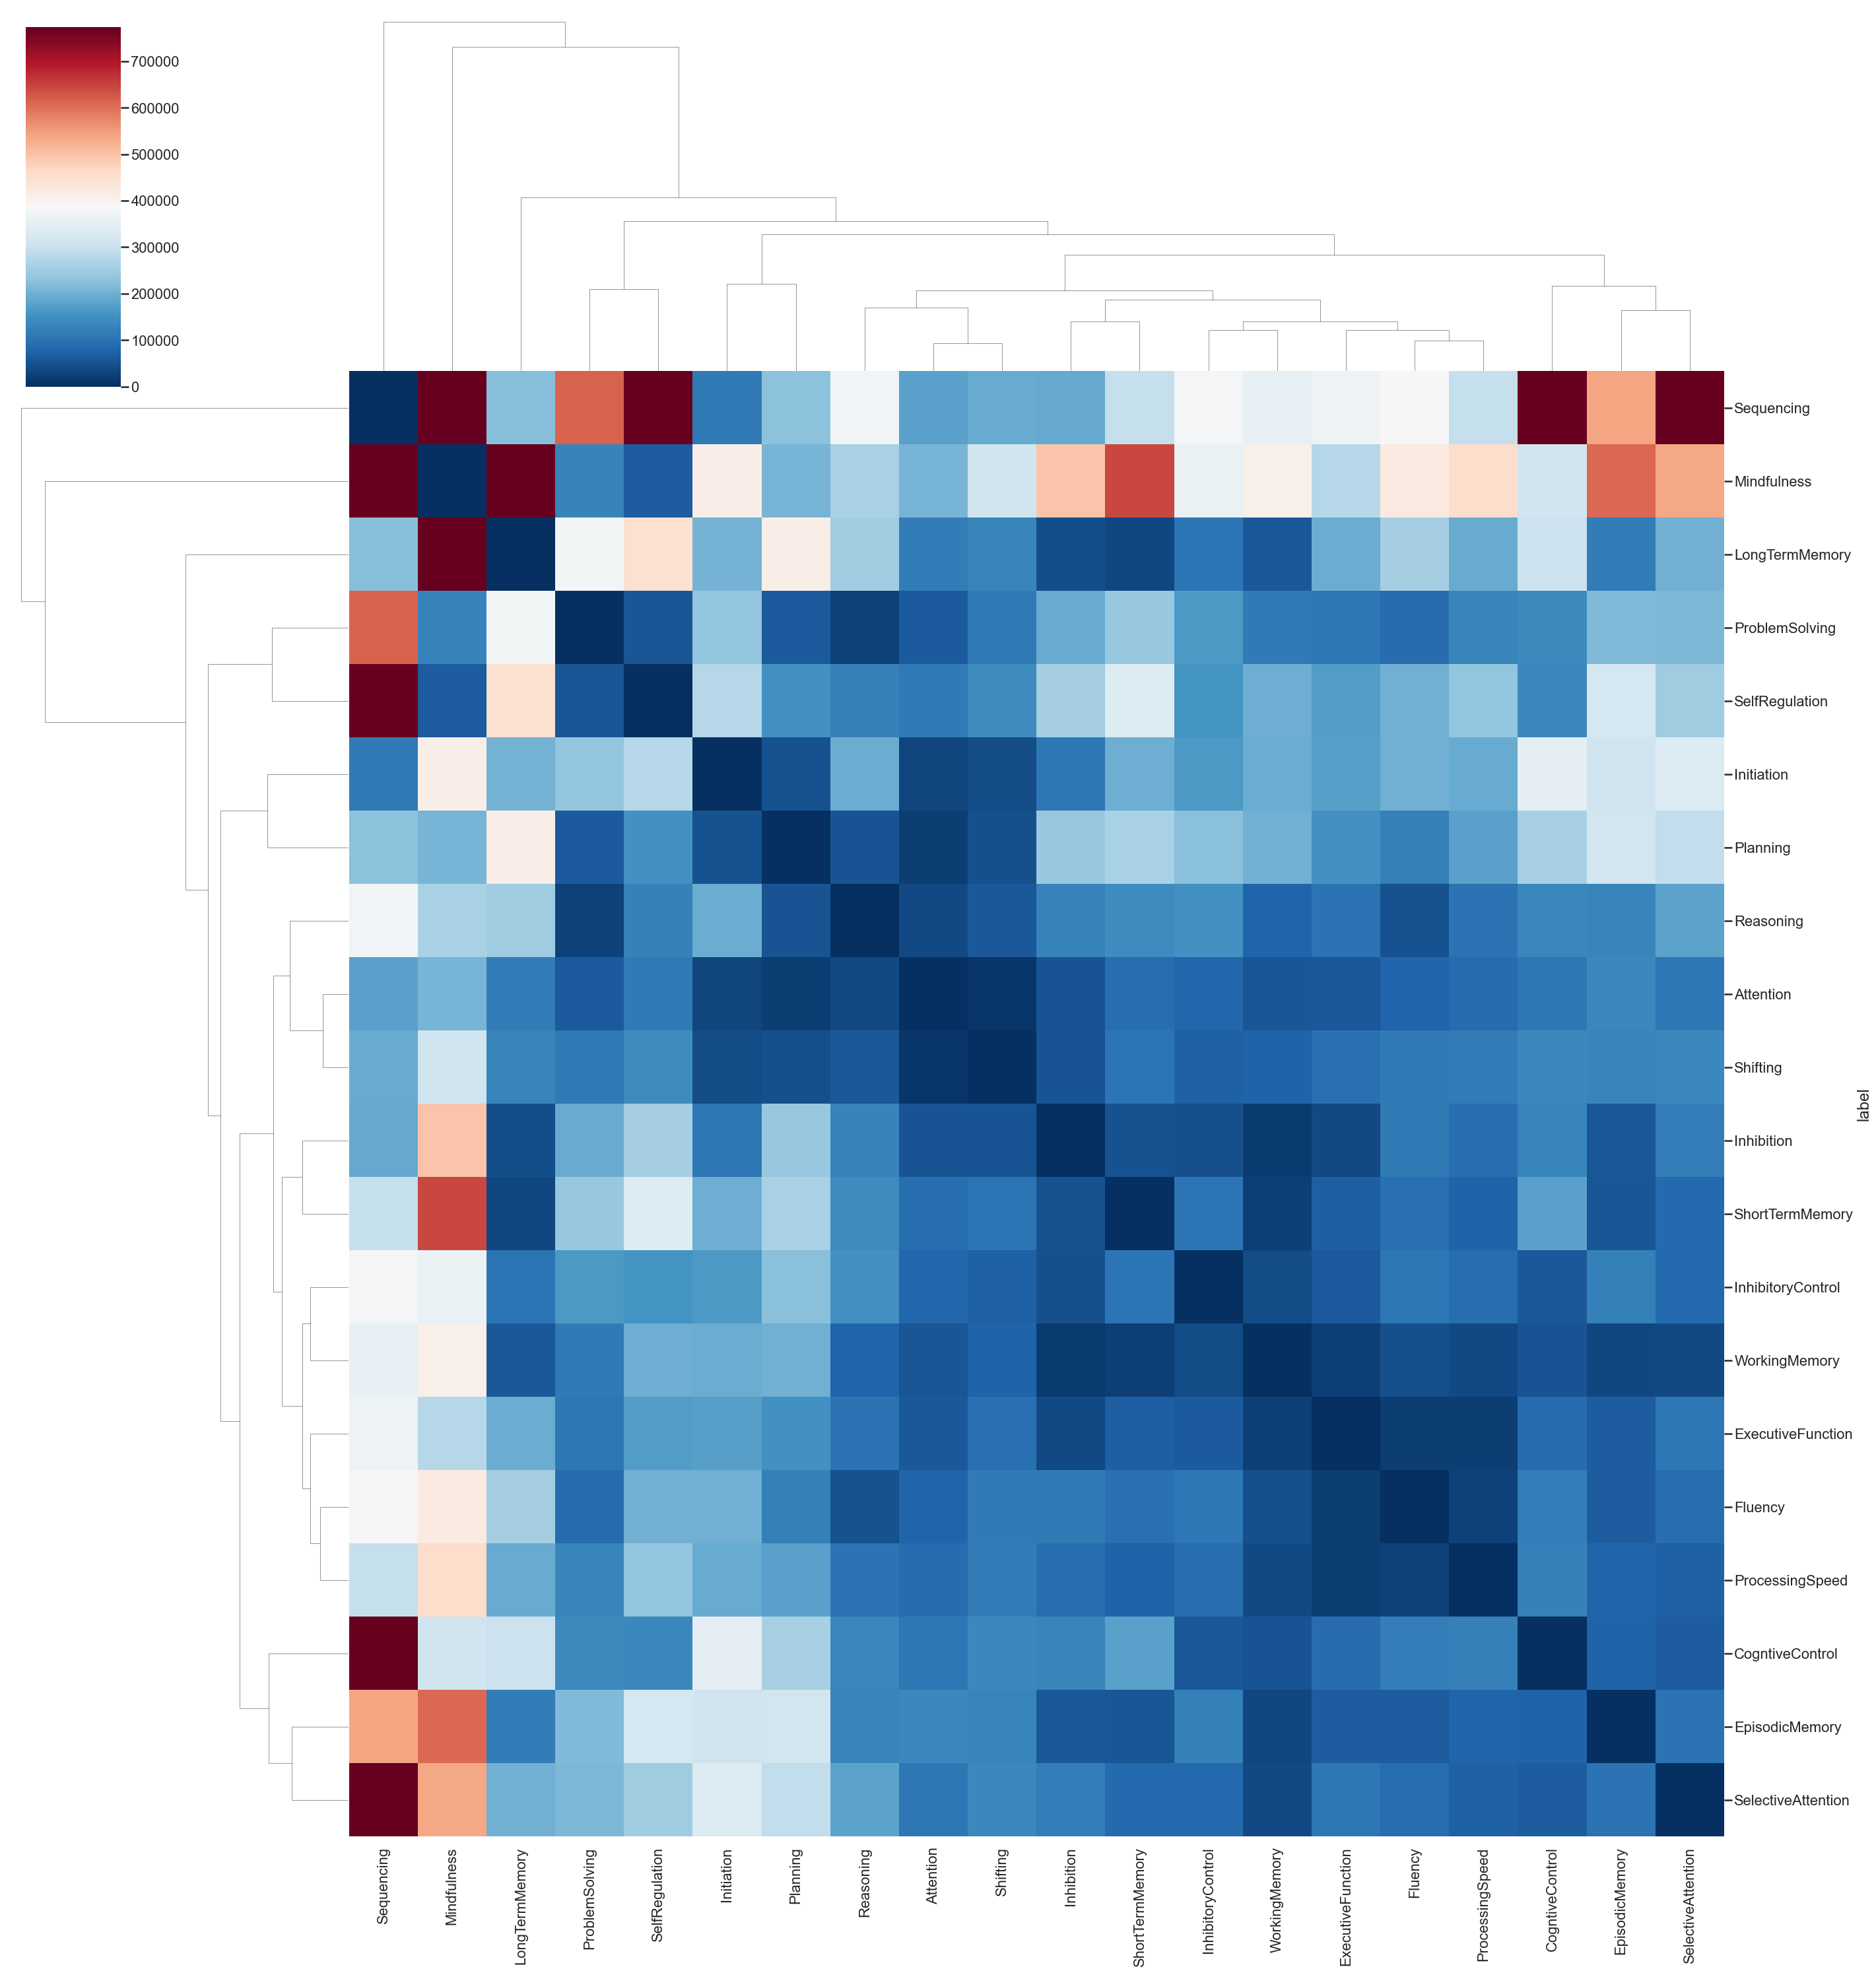

In [45]:
kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)


tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
kl_losses.drop(index=tasks, columns=tasks, inplace=True, errors='ignore')

sns.set('poster')
sns.clustermap(
  kl_losses.replace([np.inf, np.nan], 1000.0),
  figsize=(40,42),
  cmap='RdBu_r', robust=True)

plt.show()

dashbio.Clustergram(
  data=kl_losses.replace([np.inf, np.nan], 1000.0),
  column_labels=kl_losses.columns.to_list(),
  row_labels=kl_losses.index.to_list(),
  cluster='all',
  center_values=True,
  standardize=True,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

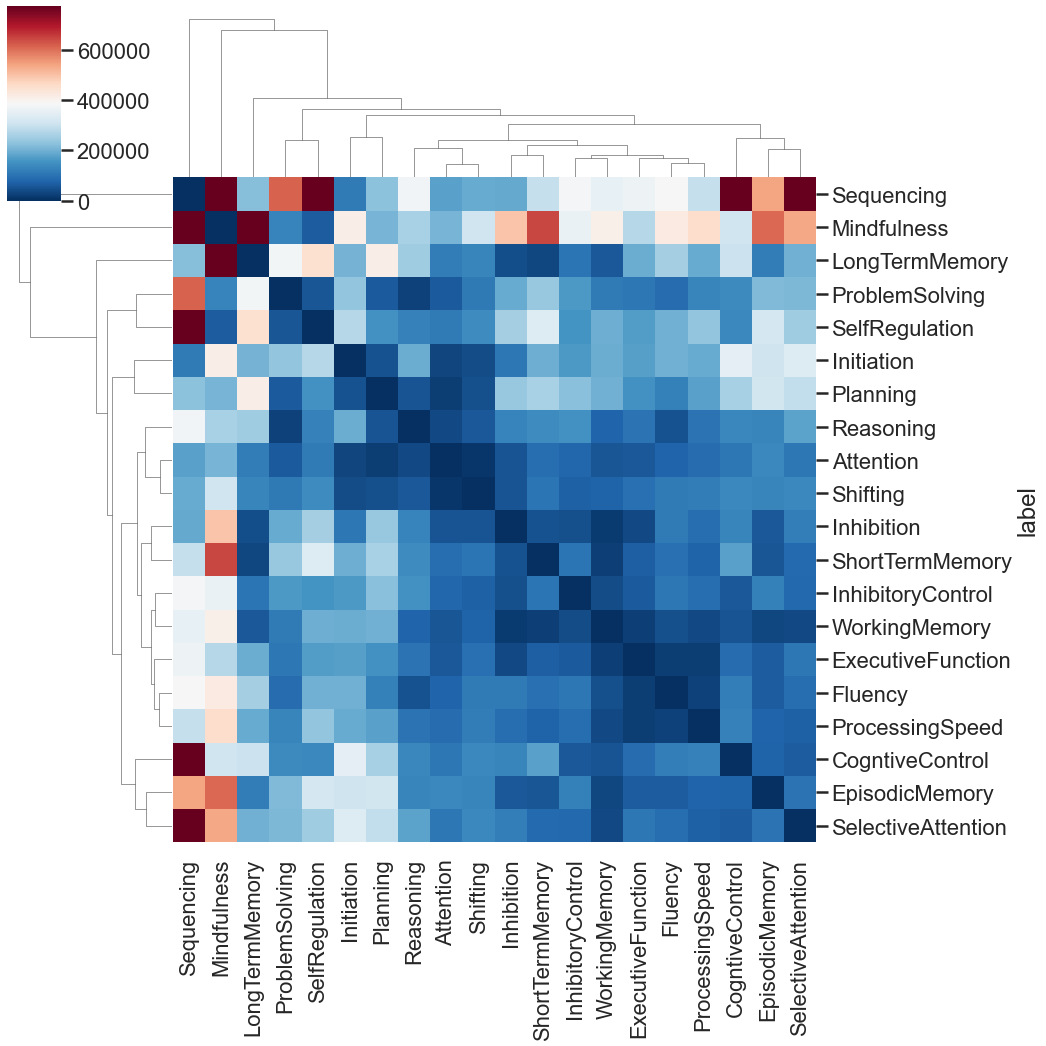

In [46]:
# popular constructs

kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)


tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
kl_losses.drop(index=tasks, columns=tasks, inplace=True, errors='ignore')
kl_losses.drop(index=rare_labels, columns=rare_labels, inplace=True, errors='ignore')

sns.set('poster')
sns.clustermap(
  kl_losses.replace([np.inf, np.nan], 1000.0),
  figsize=(15,15),
  cmap='RdBu_r', robust=True)

plt.show()

## Tasks

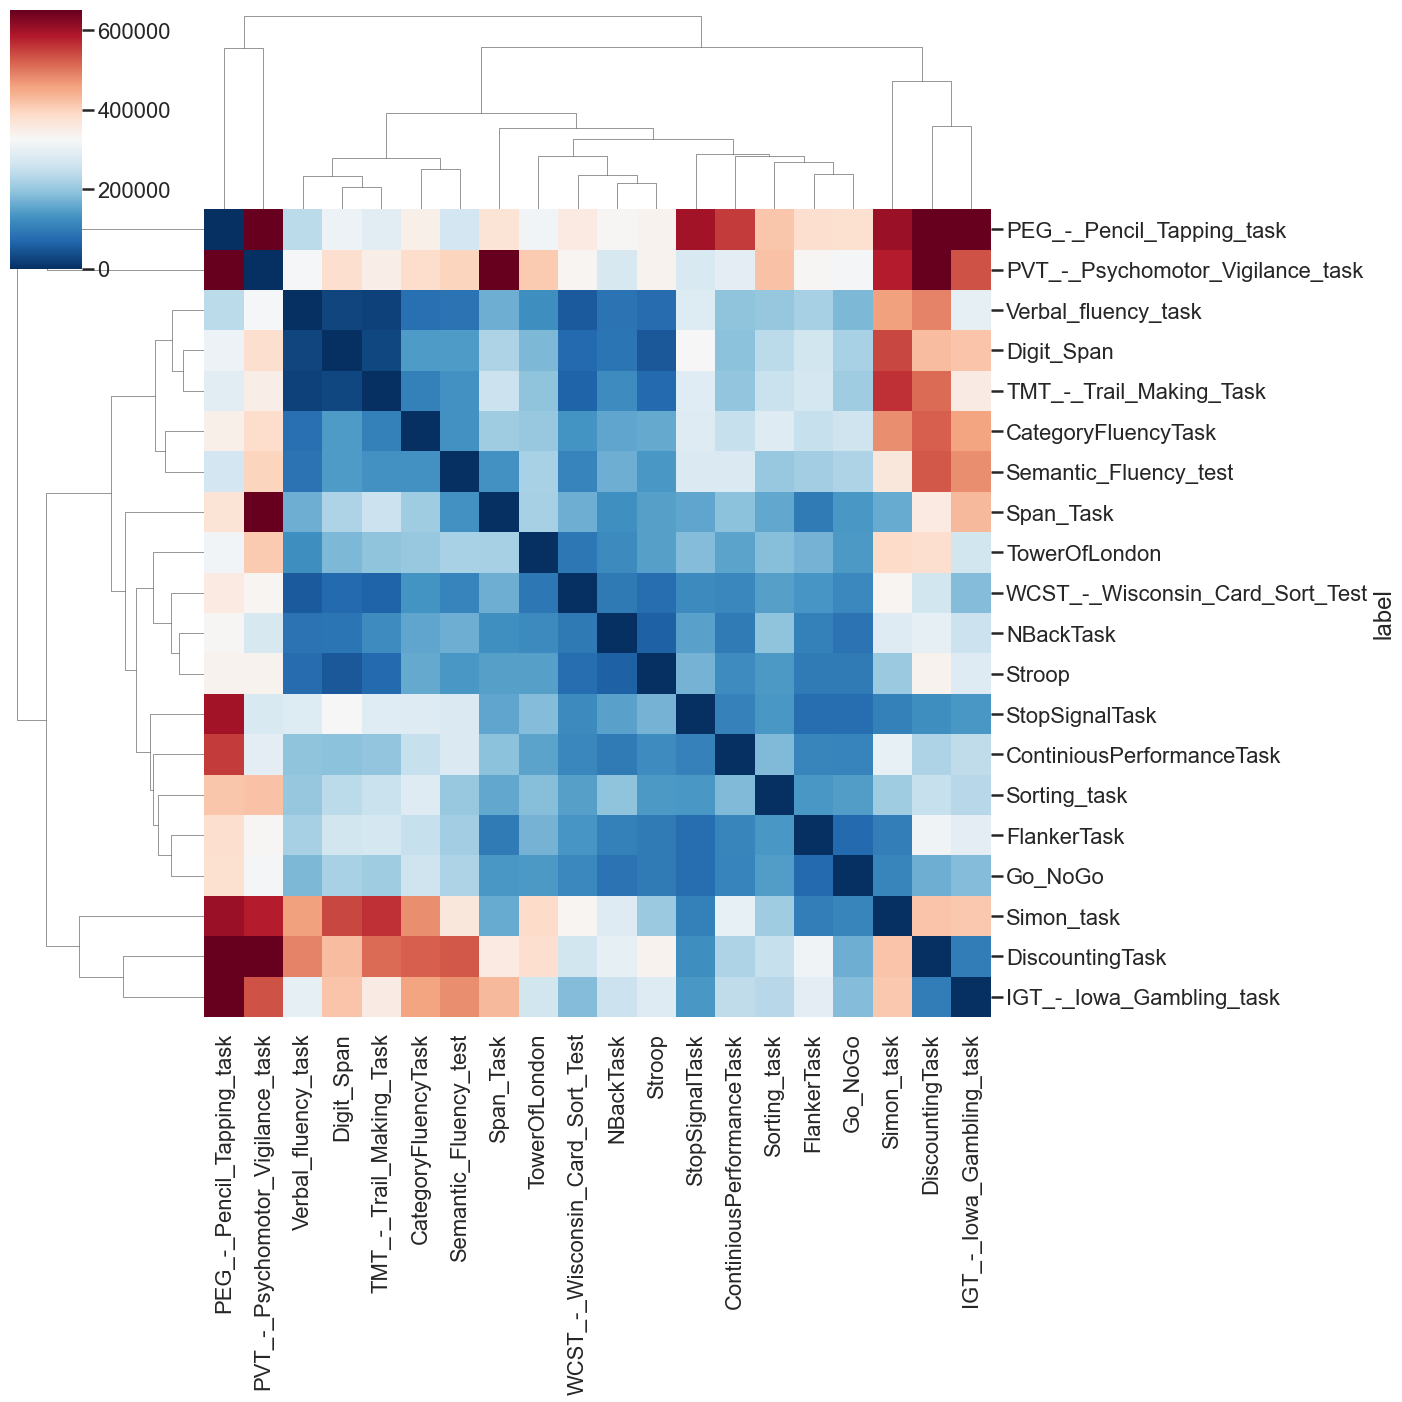

In [48]:
kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)


constructs = pubmed.query('category.str.contains("Construct")')['label'].unique()
kl_losses.drop(index=constructs, columns=constructs, inplace=True, errors='ignore')

sns.clustermap(
  kl_losses.replace([np.inf, np.nan], 1000.0),
  figsize=(20,20),
  cmap='RdBu_r', robust=True)

plt.show()